In [1]:
!pip install --upgrade music21
from music21 import converter, instrument, note, chord, stream, midi
from google.colab import files
import glob
import os
import gzip
import tarfile    
from torchvision import datasets                  
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#download the mozart data
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
        datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
        out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

# Problem 1 #

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the 114208 Notes and Chords as strings. 
There are many element types in MIDI files, so be sure to only look for Notes and Chords.
For the Chords, join the pitches of the Notes in the Chords with a . as in (D3.D2).

Print the length of your list and the number of unique Notes and Chords.


In [22]:
#download the data
download_data('drive/MyDrive/Colab')

Extracting mozart_sonatas.tar.gz
Untarring mozart_sonatas.tar


In [5]:
def order_pitches(pitches):
    """ pitches: element.pitches object where element is a chord.Chord
        returns: sorted list of strings for each pitch in the chord
    """
    return sorted(list(set([str(n) for n in pitches])))

In [6]:
def to_list(files):
  music_info = []
  for file in files:
    #parse through the files
    midi = converter.parse(file)

    #get the elements of the song
    notes_to_parse = instrument.partitionByInstrument(midi).parts.stream().recurse()

    for element in notes_to_parse:
      #determine if its a note
      if isinstance(element, note.Note):
          music_info.append(str(element.pitch))

      #if its a chord, join the notes
      elif isinstance(element, chord.Chord):
        pitches = order_pitches(element.pitches)
        music_info.append(".".join(pitches))
    
  return music_info

In [7]:
#get the paths to the mozart files
file_stuff = glob.glob('drive/MyDrive/Colab' + "/mozart_sonatas/mozart_sonatas/*.mid")
print(file_stuff)

['drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_279.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_280.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_281.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_282.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_283.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_284.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_309.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_310.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_311.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_330.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_331.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_332.mid', 'drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/piano_sonata_333.mid', 'drive/MyDrive/Colab/mozart_sonatas/m

In [8]:
#get the pitches
test = to_list(file_stuff)

In [9]:
#verify the lengths are correct
print(len(test))
print(len(list(set(test))))

114208
668


# Problem 2 #

Using the list returned in Problem 1, create the training and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.

2) Split the data into Long tensors of length 100.

3) Create the labels.

4) Randomly split the data into training, validation, and test sets using an 70/15/15 split.

5) Create the DataLoaders for these sets of data, using batch_size=128 for the training data and batch_size=32 for the validation and test data; also, set shuffle=True for the training data and False for the validation and test data (this is common practice in Deep Learning).
 

Print the length of each DataLoader (they should be 624, 535, and 535, respectively).


In [10]:
#create a dictionary with each entry corresponding to a unique pitch
pitch_nums = []
pitches = zip(list(set(test)), range(0,668))
pitch_dict = dict(pitches)

#get the numerical representations of each pitch
for pitch in test:
  pitch_nums.append(pitch_dict[pitch])

In [11]:
data_split = []
n = len(pitch_nums)
for i in range(n-100):
  #create the tensors
  tensor = pitch_nums[i:100+i]
  #create the labels
  label = pitch_nums[100+i]
  data_split.append([torch.LongTensor(tensor), label])

#split into training, validation, and test data
train_data, validation_data, test_data = random_split(data_split, [.7,.15,.15])

#create DataLoaders for each data type
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
#make sure the lengths are correct
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

624
535
535


# Problem 3 #

Create an LSTM network class.
Have a hidden layer size of 256, and include at least $3$ LSTM layers.
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for a total of at least $3$ total BatchNorm layers.
The final layer should be a Softmax activation.

Initialize the model.
Define the loss as CrossEntropyLoss, and define the optimizer as RMSprop.

Train the model for at least 30 epochs, saving the weights every epoch. 

After taking a backwards step during training, scale the gradients using 
nn.utils.clip_grad_norm_(model.parameters(), 5)
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of every epoch, calculate the validation accuracy and mean loss on the validation data.
Remember to change the model to eval() mode when running the validation data and train() when running on the training data.
You will also need to reinitialize the hidden states (h0, h1) since the batch sizes are different.

After the validation accuracy is above 60\%, plot the training and validation losses versus epochs on the same plot.
Also, plot the validation accuracy versus epochs.
Then, print the final test accuracy by running the finished model on the test data.


In [13]:
class RNN(nn.Module):
    """ Recurrent Neural Network Class """

    def __init__(self, n_notes, embedding_dim):
        super(RNN, self).__init__()
        #define the parameters of the rnn
        self.hidden_size = 256
        self.num_layers = 3
        self.n_notes = n_notes
        self.embedding = nn.Embedding(n_notes, embedding_dim)

        #define each layer
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers,batch_first=True)
        self.batch1 = nn.BatchNorm1d(self.hidden_size)
        self.linear1 = nn.Linear(self.hidden_size, self.n_notes)
        #make sure theres 3 batchnorm layers
        self.batch2 = nn.BatchNorm1d(self.n_notes)
        self.linear2 = nn.Linear(self.n_notes, self.n_notes)
        self.batch3 = nn.BatchNorm1d(self.n_notes)
        #use the softmax function for output
        self.softmax = nn.LogSoftmax(dim=1)
        #use the relu function for activation
        self.relu = nn.ReLU()

    def forward(self, x, hidden):
        embeds = self.embedding(x)
        #create the three lstm layers
        lstm_out, hidden = self.lstm(embeds, hidden)
        #use batchnorm after
        layer4 = self.batch1(lstm_out[:,-1])

        #create the linear layers followed by batchnorms
        layer5 = self.relu(self.linear1(layer4))
        layer6 = self.relu(self.linear2(self.batch2(layer5)))
        
        #use softmax for output
        return self.softmax(self.batch3(layer6)), hidden

    def init_hidden(self,batch_size):
        # initialize the hidden layers
        weight = next(self.parameters()).data
        h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        return (h0, h1)

In [24]:
# Initialize the model
model = RNN(668,32)

#define our loss function and optimization method
objective = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)
model.to(device)

#create our loop
loop = tqdm(total=len(train_loader), position=0)
loss_means = []
val_accuracies = []
val_loss_means = []

#iterate through the epochs
for epoch in range(30):
  #Initialize the hidden states
  (h0, h1) = model.init_hidden(128)
  #train the model
  model.train()

  loss_list = []
  val_loss_list = []

  for x, y_truth in train_loader:
    x, y_truth = x.to(device), y_truth.to(device)
    optimizer.zero_grad()             # Zero out the gradients
    
    #Pass data through the model to get output and new hidden states
    y_hat, (h0, h1) = model(x, (h0, h1))

    #Disable automatic differentiation on the hidden states
    h0 = h0.detach()
    h1 = h1.detach()

    loss = objective(y_hat, y_truth)
    loss_list.append(loss.item())

    #update the loop
    loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch,loss.item()))
    loop.update()

    loss.backward()                   # Backpropagate to compute gradients
    optimizer.step()                  # Optimize and update the weights

    #scale the gradients
    nn.utils.clip_grad_norm_(model.parameters(), 5)

  loss_means.append(np.mean(loss_list))

  #get the validation loss and accuracy
  validation = 0
  model.eval()
  for x_truth, y_truth in validation_loader:
    x_truth, y_truth = x_truth.to(device), y_truth.to(device)
    (h0, h1) = model.init_hidden(len(y_truth))
    y_hat, _ = model(x_truth, (h0, h1))

    loss = objective(y_hat, y_truth)
    val_loss_list.append(loss.item())

    # sum how many elements equal each other between the true and predicted
    # batches, then divide by the number of elements in the batch
    validation += sum(torch.eq(y_truth, y_hat.argmax(1))) / len(y_truth)

  mean_validation_accuracy = validation.item() / len(validation_loader)
  if mean_validation_accuracy > .6:
    break
  val_accuracies.append(mean_validation_accuracy)
  val_loss_means.append(np.mean(val_loss_list))
  torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,},"/content/gdrive/MyDrive")

loop.close()

epoch:0, loss:4.6276: 100%|██████████| 624/624 [01:22<00:00,  7.58it/s]
epoch:29, loss:0.3605: : 18720it [15:18, 20.38it/s]


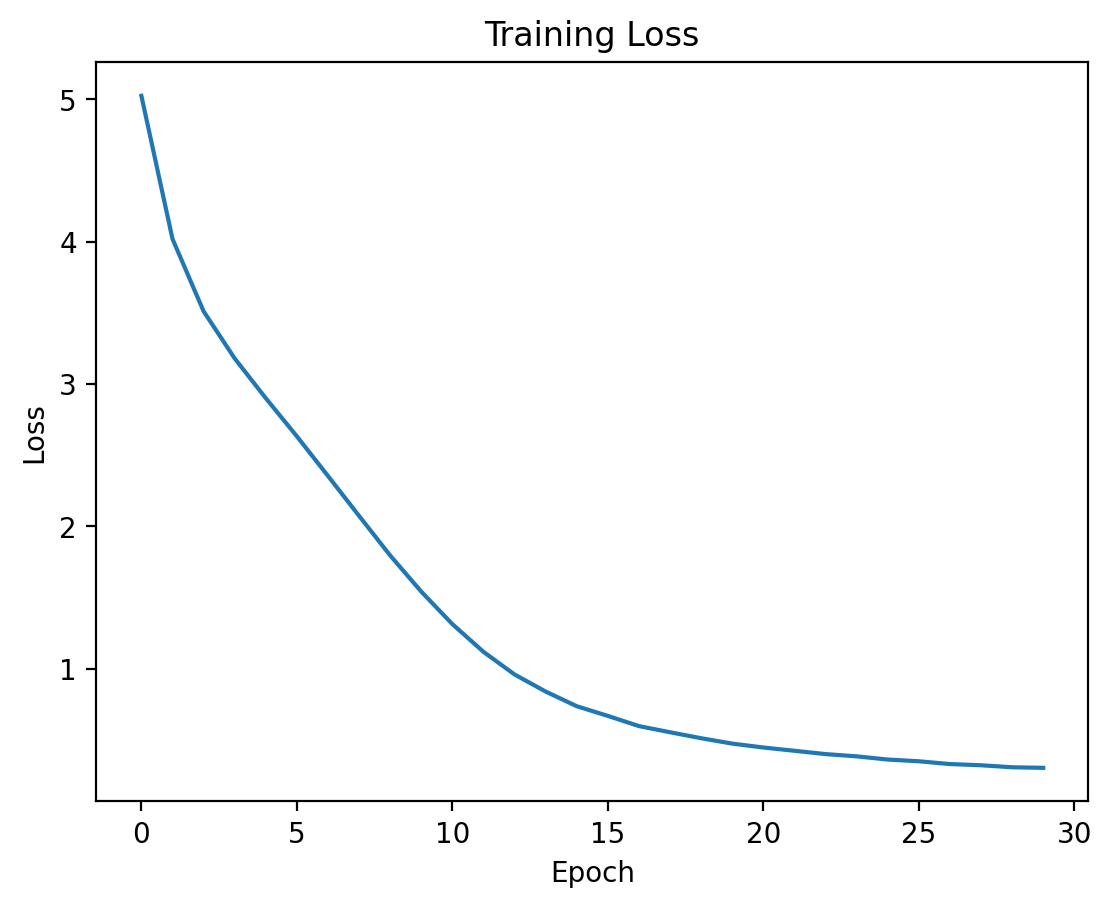

In [25]:
#plot the training loss
plt.plot(loss_means)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Training Loss")
plt.show()

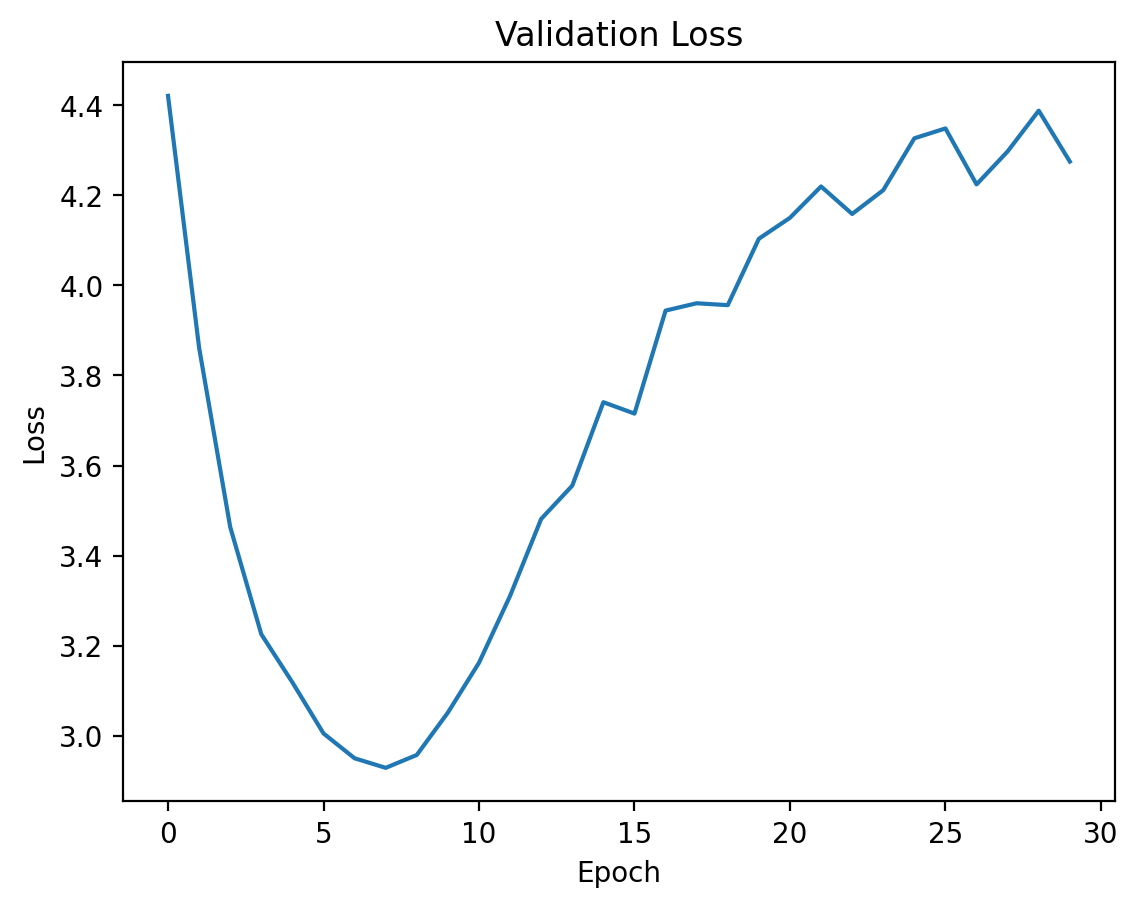

In [26]:
#plot the validation loss
plt.plot(val_loss_means)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Validation Loss")
plt.show()

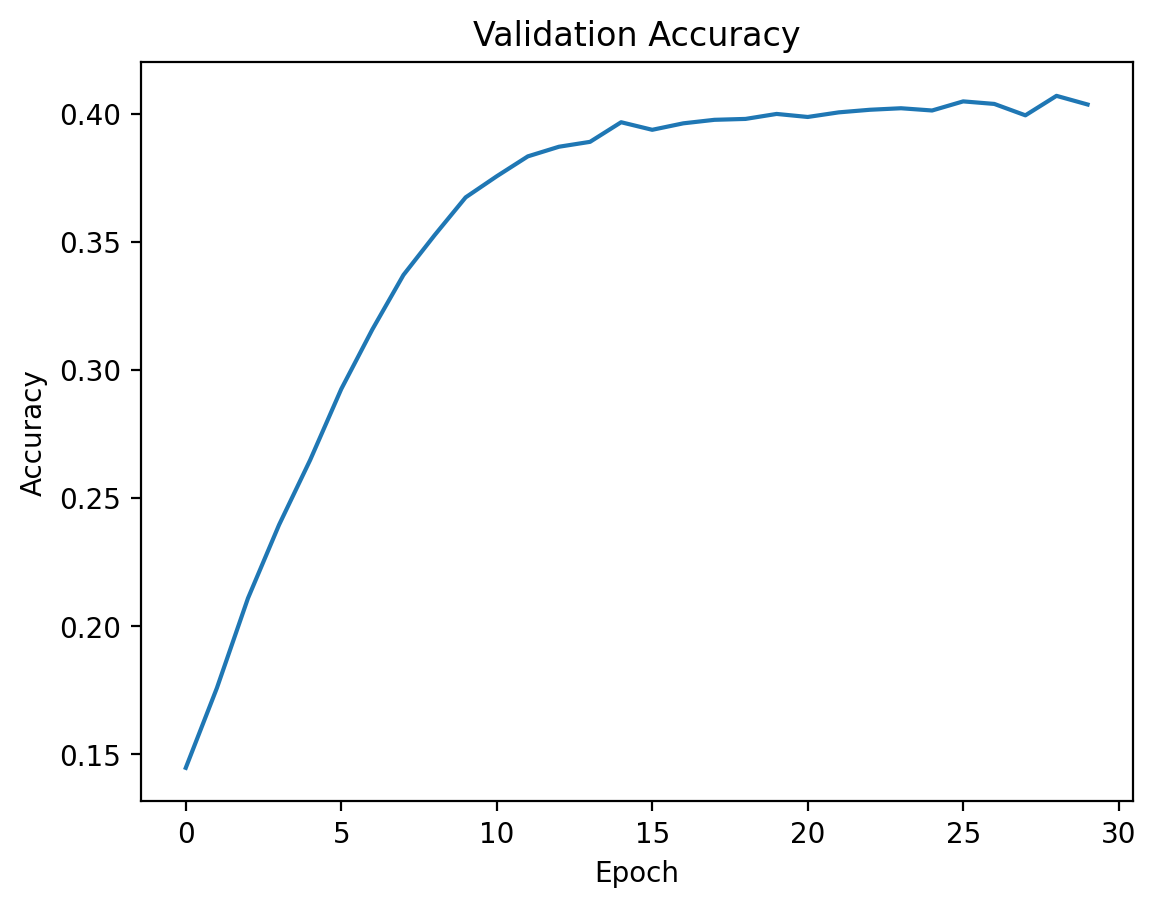

In [27]:
#plot the validation accuracy
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy")
plt.show()

In [28]:
#print the final test accuracy
test = 0
for x_truth, y_truth in test_loader:
  x_truth, y_truth = x_truth.to(device), y_truth.to(device)
  (h0, h1) = model.init_hidden(len(y_truth))
  y_hat, _ = model(x_truth, (h0, h1))

  # sum how many elements equal each other between the true and predicted
  # batches, then divide by the number of elements in the batch
  test += sum(torch.eq(y_truth, y_hat.argmax(1))) / len(y_truth)

mean_test_accuracy = test.item() / len(test_loader)
print(mean_test_accuracy)

0.409696261682243


# Problem 4 #

Write a function that randomly chooses a sequence in the test data (which has length 100) and predicts the next $n$ elements, defaulting to 500. 
Combine the initial sequence with the predicted elements, convert them to pitches, and return this list of 600 pitches.

In [ ]:
def load_model(filename):
    """ Load a saved model to continue training or evaluate """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # n_notes is the number of unique pitches
    model = Network(n_notes,32)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)

    checkpoint = torch.load(filename,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.eval() # Toggle evaluation mode

    return model, criterion, optimizer

# Problem 5 # 

Convert the predictions from Problem 4 into Music21 Note and Chord objects and save it as 'mozart.mid'.